In [1]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p-latest


In [5]:
import os
import glob
import numpy as np
import zarr
import pandas as pd
import cv2
from pathlib import Path
from tqdm import tqdm
import numcodecs
from sklearn.model_selection import train_test_split

# --- CONFIGURATION ---
BASE_PATH = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER1/yasin-vitaminp/public-datasets/NuInsSeg")
OUTPUT_BASE = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/nuinsseg/zarr_data")

# Following NuInsSeg paper recommendation with fixed random state for reproducibility
RANDOM_STATE = 19
TRAIN_RATIO = 0.70  # 70% train
VAL_RATIO = 0.15    # 15% val
TEST_RATIO = 0.15   # 15% test

PATCH_SIZE = 512
cv2.setNumThreads(0)

# All available tissue types in NuInsSeg
ALL_TISSUES = [
    'human bladder', 'human brain', 'human cardia', 'human cerebellum',
    'human epiglottis', 'human jejunum', 'human kidney', 'human liver',
    'human lung', 'human melanoma', 'human muscle', 'human oesophagus',
    'human pancreas', 'human peritoneum', 'human placenta', 'human pylorus',
    'human rectum', 'human salivory gland', 'human spleen', 'human testis',
    'human tongue', 'human tonsile', 'human umbilical cord',
    'mouse fat (white and brown)_subscapula', 'mouse femur', 'mouse heart',
    'mouse kidney', 'mouse liver', 'mouse muscle_tibia', 'mouse spleen',
    'mouse thymus'
]

# ---------------------------------------------------------------------
# 1. Padding Logic
# ---------------------------------------------------------------------
def pad_to_512_multiple(img):
    """Pad image/mask to be evenly divisible by 512"""
    h, w = img.shape[:2]
    target_h = max(int(np.ceil(h / PATCH_SIZE) * PATCH_SIZE), PATCH_SIZE)
    target_w = max(int(np.ceil(w / PATCH_SIZE) * PATCH_SIZE), PATCH_SIZE)
    
    pad_h, pad_w = target_h - h, target_w - w
    if pad_h == 0 and pad_w == 0:
        return img
    
    # Handle both 2D (mask) and 3D (image) arrays
    if img.ndim == 3:
        padding = ((0, pad_h), (0, pad_w), (0, 0))
    else:
        padding = ((0, pad_h), (0, pad_w))
    
    return np.pad(img, padding, mode='constant', constant_values=0)

# ---------------------------------------------------------------------
# 2. Process Single Image Pair
# ---------------------------------------------------------------------
def process_image_pair(img_path, mask_path, tissue_name):
    """
    Process one image+mask pair from NuInsSeg:
    1. Load image from 'tissue images' folder (PNG)
    2. Load instance mask from 'label masks' folder (TIF - already instance format)
    3. Pad to 512 multiples
    4. Extract 512x512 patches
    """
    try:
        # --- A. Load Image (PNG) ---
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"⚠️  Cannot read image: {img_path}")
            return None
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h_img, w_img = img.shape[:2]
        
        # --- B. Load Instance Mask (TIF - already in instance format) ---
        instance_mask = cv2.imread(str(mask_path), cv2.IMREAD_ANYDEPTH | cv2.IMREAD_GRAYSCALE)
        if instance_mask is None:
            print(f"⚠️  Cannot read mask: {mask_path}")
            return None
        
        # Convert to int32 for instance IDs
        instance_mask = instance_mask.astype(np.int32)
        
        # --- C. Pad to 512 Multiples ---
        img_padded = pad_to_512_multiple(img)
        mask_padded = pad_to_512_multiple(instance_mask)
        h_pad, w_pad = img_padded.shape[:2]
        
        # --- D. Extract 512x512 Patches ---
        img_stack, mask_stack, metadata_list = [], [], []
        
        for y in range(0, h_pad, PATCH_SIZE):
            for x in range(0, w_pad, PATCH_SIZE):
                crop_img = img_padded[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
                crop_mask = mask_padded[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
                
                # Ensure full 512x512 patch
                if crop_img.shape[0] == PATCH_SIZE and crop_img.shape[1] == PATCH_SIZE:
                    img_stack.append(crop_img)
                    mask_stack.append(crop_mask)
                    metadata_list.append({
                        'tissue_type': tissue_name,
                        'original_file': img_path.name,
                        'x': x,
                        'y': y,
                        'original_height': h_img,
                        'original_width': w_img
                    })
        
        if not img_stack:
            print(f"⚠️  No patches extracted for {img_path.name}")
            return None
        
        return {
            'images': np.stack(img_stack, axis=0),
            'masks': np.stack(mask_stack, axis=0),
            'metadata': metadata_list
        }
    
    except Exception as e:
        print(f"❌ Error processing {img_path.name}: {e}")
        import traceback
        traceback.print_exc()
        return None

# ---------------------------------------------------------------------
# 3. Collect All Image-Mask Pairs
# ---------------------------------------------------------------------
def collect_all_pairs():
    """
    Scan all tissue directories and collect (image, mask, tissue) tuples.
    Images are .png, masks are .tif
    """
    all_pairs = []
    
    for tissue in ALL_TISSUES:
        tissue_dir = BASE_PATH / tissue
        
        if not tissue_dir.exists():
            print(f"⚠️  Tissue directory not found: {tissue}")
            continue
        
        img_dir = tissue_dir / "tissue images"
        mask_dir = tissue_dir / "label masks"
        
        if not img_dir.exists() or not mask_dir.exists():
            print(f"⚠️  Missing subdirectories in {tissue}")
            continue
        
        # Find all PNG images
        img_files = sorted(img_dir.glob("*.png"))
        
        for img_path in img_files:
            # Construct corresponding TIF mask path
            mask_path = mask_dir / (img_path.stem + ".tif")
            
            if mask_path.exists():
                all_pairs.append((img_path, mask_path, tissue))
            else:
                print(f"   ⚠️  No mask for {tissue}/{img_path.name}")
    
    return all_pairs

# ---------------------------------------------------------------------
# 4. Split Data into Train/Val/Test
# ---------------------------------------------------------------------
def split_data(all_pairs):
    """
    Split image pairs into train/val/test following NuInsSeg paper approach.
    Uses sklearn with fixed random_state=19 for reproducibility.
    """
    np.random.seed(RANDOM_STATE)
    
    # First split: separate test set
    train_val_pairs, test_pairs = train_test_split(
        all_pairs,
        test_size=TEST_RATIO,
        random_state=RANDOM_STATE,
        shuffle=True
    )
    
    # Second split: separate validation from training
    val_size_adjusted = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)
    train_pairs, val_pairs = train_test_split(
        train_val_pairs,
        test_size=val_size_adjusted,
        random_state=RANDOM_STATE,
        shuffle=True
    )
    
    return train_pairs, val_pairs, test_pairs

# ---------------------------------------------------------------------
# 5. Process and Save Split
# ---------------------------------------------------------------------
def process_split(pairs, split_name):
    """
    Process all image pairs for a split and save to zarr.
    """
    if not pairs:
        print(f"⚠️  No pairs for {split_name}")
        return 0, 0
    
    print(f"\n📂 Processing {split_name} ({len(pairs)} images)")
    
    # Process all pairs
    results = []
    for img_path, mask_path, tissue in tqdm(pairs, desc=f"  {split_name}", leave=False):
        result = process_image_pair(img_path, mask_path, tissue)
        if result is not None:
            results.append(result)
    
    if not results:
        print(f"⚠️  No valid results for {split_name}")
        return 0, 0
    
    # --- Aggregate All Patches ---
    all_images = []
    all_masks = []
    all_metadata = []
    
    for result in results:
        all_images.append(result['images'])
        all_masks.append(result['masks'])
        all_metadata.extend(result['metadata'])
    
    # Concatenate all patches
    final_images = np.concatenate(all_images, axis=0)
    final_masks = np.concatenate(all_masks, axis=0)
    
    # --- Save to Zarr ---
    split_dir = OUTPUT_BASE / split_name
    os.makedirs(split_dir, exist_ok=True)
    compressor = numcodecs.Blosc(cname='zstd', clevel=3)
    
    # Save images
    z_img = zarr.open_array(
        str(split_dir / 'images.zarr'),
        mode='w',
        shape=final_images.shape,
        chunks=(1, 512, 512, 3),
        dtype='uint8',
        compressor=compressor
    )
    z_img[:] = final_images
    
    # Save instance masks
    z_mask = zarr.open_array(
        str(split_dir / 'nuclei_masks.zarr'),
        mode='w',
        shape=final_masks.shape,
        chunks=(1, 512, 512),
        dtype='int32',
        compressor=compressor
    )
    z_mask[:] = final_masks
    
    # Save metadata
    pd.DataFrame(all_metadata).to_csv(
        split_dir / 'metadata.csv',
        index=False
    )
    
    # Get instance stats
    unique_instances = np.unique(final_masks)
    num_instances = len(unique_instances[unique_instances > 0])
    
    print(f"   ✅ {split_name}: {len(final_images)} patches, {num_instances} nuclei instances")
    
    return len(final_images), num_instances

# ---------------------------------------------------------------------
# 6. Main Processing Pipeline
# ---------------------------------------------------------------------
def main():
    print("=" * 70)
    print("🔬 NuInsSeg Dataset → Zarr with Train/Val/Test Split")
    print("=" * 70)
    
    # Collect all image-mask pairs
    print("\n📊 Collecting all image-mask pairs...")
    all_pairs = collect_all_pairs()
    
    print(f"\n✅ Found {len(all_pairs)} total image-mask pairs")
    
    # Count per tissue
    tissue_counts = {}
    for _, _, tissue in all_pairs:
        tissue_counts[tissue] = tissue_counts.get(tissue, 0) + 1
    
    print("\n📊 Images per tissue:")
    for tissue, count in sorted(tissue_counts.items()):
        print(f"   {tissue}: {count}")
    
    # Split data
    print(f"\n📂 Splitting data (seed={RANDOM_STATE}):")
    print(f"   Train: {TRAIN_RATIO*100:.0f}%")
    print(f"   Val:   {VAL_RATIO*100:.0f}%")
    print(f"   Test:  {TEST_RATIO*100:.0f}%")
    
    train_pairs, val_pairs, test_pairs = split_data(all_pairs)
    
    print(f"\n   Train: {len(train_pairs)} images")
    print(f"   Val:   {len(val_pairs)} images")
    print(f"   Test:  {len(test_pairs)} images")
    
    # Create output directory
    OUTPUT_BASE.mkdir(parents=True, exist_ok=True)
    
    # Process each split
    train_patches, train_nuclei = process_split(train_pairs, 'nuinsseg_train')
    val_patches, val_nuclei = process_split(val_pairs, 'nuinsseg_val')
    test_patches, test_nuclei = process_split(test_pairs, 'nuinsseg_test')
    
    # --- Summary Statistics ---
    print("\n" + "=" * 70)
    print("✅ PROCESSING COMPLETE")
    print("=" * 70)
    print(f"Total images processed: {len(all_pairs)}")
    print(f"Total patches created: {train_patches + val_patches + test_patches}")
    print(f"Total nuclei instances: {train_nuclei + val_nuclei + test_nuclei}")
    
    print("\n" + "─" * 70)
    print("📊 Per-Split Statistics:")
    print("─" * 70)
    
    splits = [
        ('nuinsseg_train', len(train_pairs), train_patches, train_nuclei),
        ('nuinsseg_val', len(val_pairs), val_patches, val_nuclei),
        ('nuinsseg_test', len(test_pairs), test_patches, test_nuclei)
    ]
    
    for split_name, num_imgs, num_patches, num_nuclei in splits:
        print(f"\n{split_name.upper()}:")
        print(f"   Original images: {num_imgs}")
        print(f"   Total patches: {num_patches}")
        print(f"   Total nuclei: {num_nuclei}")
        if num_patches > 0:
            print(f"   Avg nuclei/patch: {num_nuclei/num_patches:.1f}")
    
    print("\n" + "=" * 70)
    print(f"Output directory: {OUTPUT_BASE}")
    print("=" * 70)
    
    # Create split info file
    create_split_info_file(all_pairs, train_pairs, val_pairs, test_pairs, tissue_counts)

def create_split_info_file(all_pairs, train_pairs, val_pairs, test_pairs, tissue_counts):
    """Create a text file documenting the split."""
    info_file = OUTPUT_BASE / "split_info.txt"
    
    with open(info_file, 'w') as f:
        f.write("NuInsSeg Dataset Split Information\n")
        f.write("=" * 70 + "\n\n")
        f.write("Split Strategy: Random split across all tissues\n")
        f.write(f"Random seed: {RANDOM_STATE} (following NuInsSeg paper)\n")
        f.write(f"Split ratio: {TRAIN_RATIO:.0%} train / {VAL_RATIO:.0%} val / {TEST_RATIO:.0%} test\n\n")
        
        f.write(f"Total images: {len(all_pairs)}\n")
        f.write(f"  Train: {len(train_pairs)}\n")
        f.write(f"  Val:   {len(val_pairs)}\n")
        f.write(f"  Test:  {len(test_pairs)}\n\n")
        
        f.write("Images per tissue:\n")
        f.write("-" * 70 + "\n")
        for tissue, count in sorted(tissue_counts.items()):
            f.write(f"  {tissue}: {count}\n")
        
        f.write("\n" + "=" * 70 + "\n")
        f.write("Directory Structure:\n")
        f.write("  nuinsseg_train/\n")
        f.write("    ├── images.zarr\n")
        f.write("    ├── nuclei_masks.zarr\n")
        f.write("    └── metadata.csv\n")
        f.write("  nuinsseg_val/\n")
        f.write("    └── (same structure)\n")
        f.write("  nuinsseg_test/\n")
        f.write("    └── (same structure)\n")
    
    print(f"\n📄 Split info saved to: {info_file}")

if __name__ == "__main__":
    main()

🔬 NuInsSeg Dataset → Zarr with Train/Val/Test Split

📊 Collecting all image-mask pairs...

✅ Found 665 total image-mask pairs

📊 Images per tissue:
   human bladder: 12
   human brain: 12
   human cardia: 12
   human cerebellum: 12
   human epiglottis: 11
   human jejunum: 10
   human kidney: 11
   human liver: 40
   human lung: 11
   human melanoma: 12
   human muscle: 9
   human oesophagus: 47
   human pancreas: 44
   human peritoneum: 12
   human placenta: 40
   human pylorus: 12
   human rectum: 12
   human salivory gland: 44
   human spleen: 34
   human testis: 12
   human tongue: 40
   human tonsile: 12
   human umbilical cord: 11
   mouse fat (white and brown)_subscapula: 42
   mouse femur: 6
   mouse heart: 28
   mouse kidney: 40
   mouse liver: 36
   mouse muscle_tibia: 28
   mouse spleen: 7
   mouse thymus: 6

📂 Splitting data (seed=19):
   Train: 70%
   Val:   15%
   Test:  15%

   Train: 465 images
   Val:   100 images
   Test:  100 images

📂 Processing nuinsseg_train (465 

   ✅ nuinsseg_train: 465 patches, 490 nuclei instances

📂 Processing nuinsseg_val (100 images)


   ✅ nuinsseg_val: 100 patches, 290 nuclei instances

📂 Processing nuinsseg_test (100 images)


   ✅ nuinsseg_test: 100 patches, 433 nuclei instances

✅ PROCESSING COMPLETE
Total images processed: 665
Total patches created: 665
Total nuclei instances: 1213

──────────────────────────────────────────────────────────────────────
📊 Per-Split Statistics:
──────────────────────────────────────────────────────────────────────

NUINSSEG_TRAIN:
   Original images: 465
   Total patches: 465
   Total nuclei: 490
   Avg nuclei/patch: 1.1

NUINSSEG_VAL:
   Original images: 100
   Total patches: 100
   Total nuclei: 290
   Avg nuclei/patch: 2.9

NUINSSEG_TEST:
   Original images: 100
   Total patches: 100
   Total nuclei: 433
   Avg nuclei/patch: 4.3

Output directory: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/nuinsseg/zarr_data

📄 Split info saved to: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/nuinsseg/zarr_data/split_info.txt



🔍 DATA INTEGRITY CHECK

✅ All checks passed! Dataset looks good.


📊 NuInsSeg DATASET SUMMARY

Total splits: 3
Total patches: 665
Total nuclei (estimated): 37055
Avg nuclei/patch: 55.7

──────────────────────────────────────────────────────────────────────
Per-split breakdown:
──────────────────────────────────────────────────────────────────────
   nuinsseg_train: 465 patches, ~25751 nuclei (avg: 55.4/patch)
      (estimated from 100 sampled patches)
   nuinsseg_val: 100 patches, ~5145 nuclei (avg: 51.5/patch)
      (estimated from 100 sampled patches)
   nuinsseg_test: 100 patches, ~6159 nuclei (avg: 61.6/patch)
      (estimated from 100 sampled patches)

──────────────────────────────────────────────────────────────────────
Tissue type distribution:
──────────────────────────────────────────────────────────────────────

   nuinsseg_train:
      human oesophagus: 34 patches
      human salivory gland: 32 patches
      human tongue: 32 patches
      human placenta: 29 patches
      m

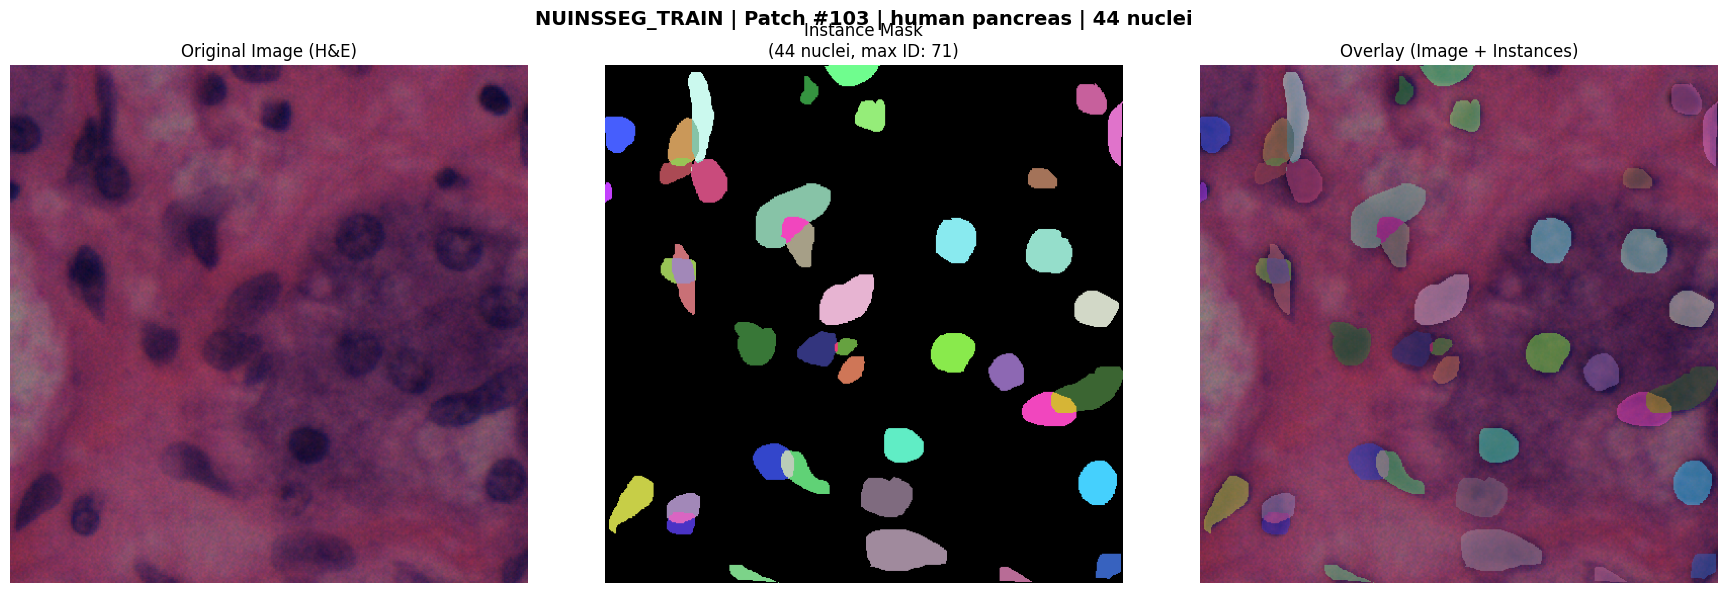

        ✅ Visualization complete

   [2/3] Patch #144
        Nuclei in patch: 84
        Size range: 3-3195 pixels (avg: 1033)
        Tissue type: human placenta
        Original file: human_placenta_35.png
        Position: x=0, y=0
        Original size: 512x512


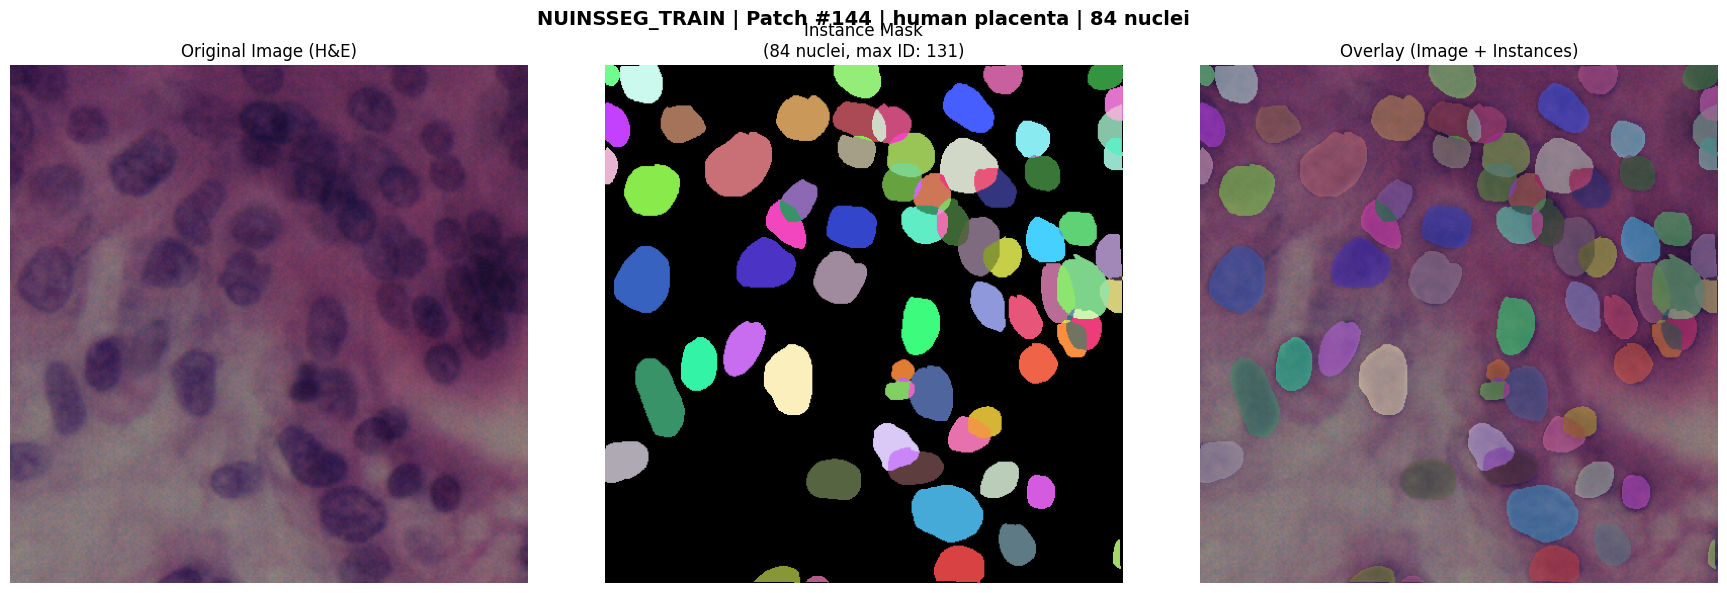

        ✅ Visualization complete

   [3/3] Patch #368
        Nuclei in patch: 50
        Size range: 86-2889 pixels (avg: 1102)
        Tissue type: human peritoneum
        Original file: human_peritoneum_11.png
        Position: x=0, y=0
        Original size: 512x512


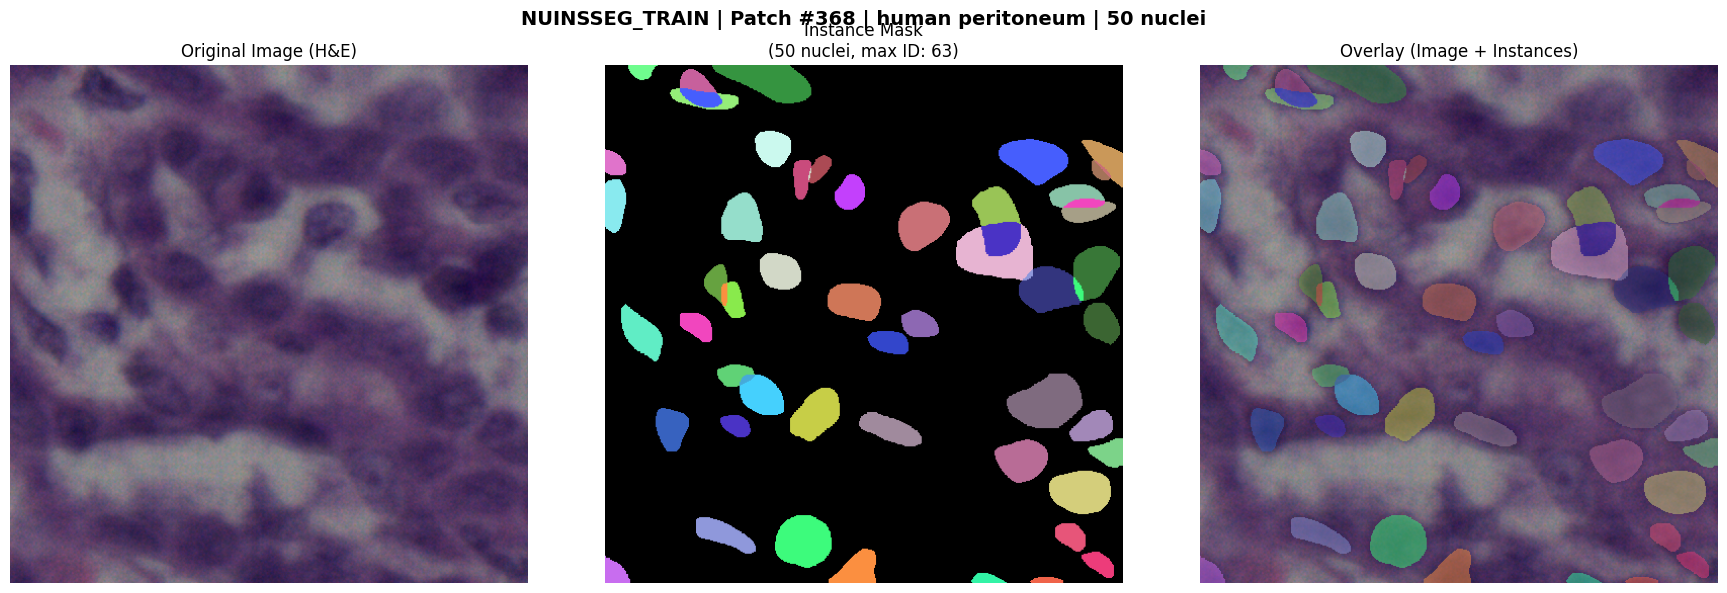

        ✅ Visualization complete

──────────────────────────────────────────────────────────────────────
📊 NUINSSEG_VAL
   Total patches: 100
   Showing: 3 random patches
──────────────────────────────────────────────────────────────────────

   [1/3] Patch #8
        Nuclei in patch: 15
        Size range: 58-2856 pixels (avg: 1280)
        Tissue type: human liver
        Original file: human_liver_29.png
        Position: x=0, y=0
        Original size: 512x512


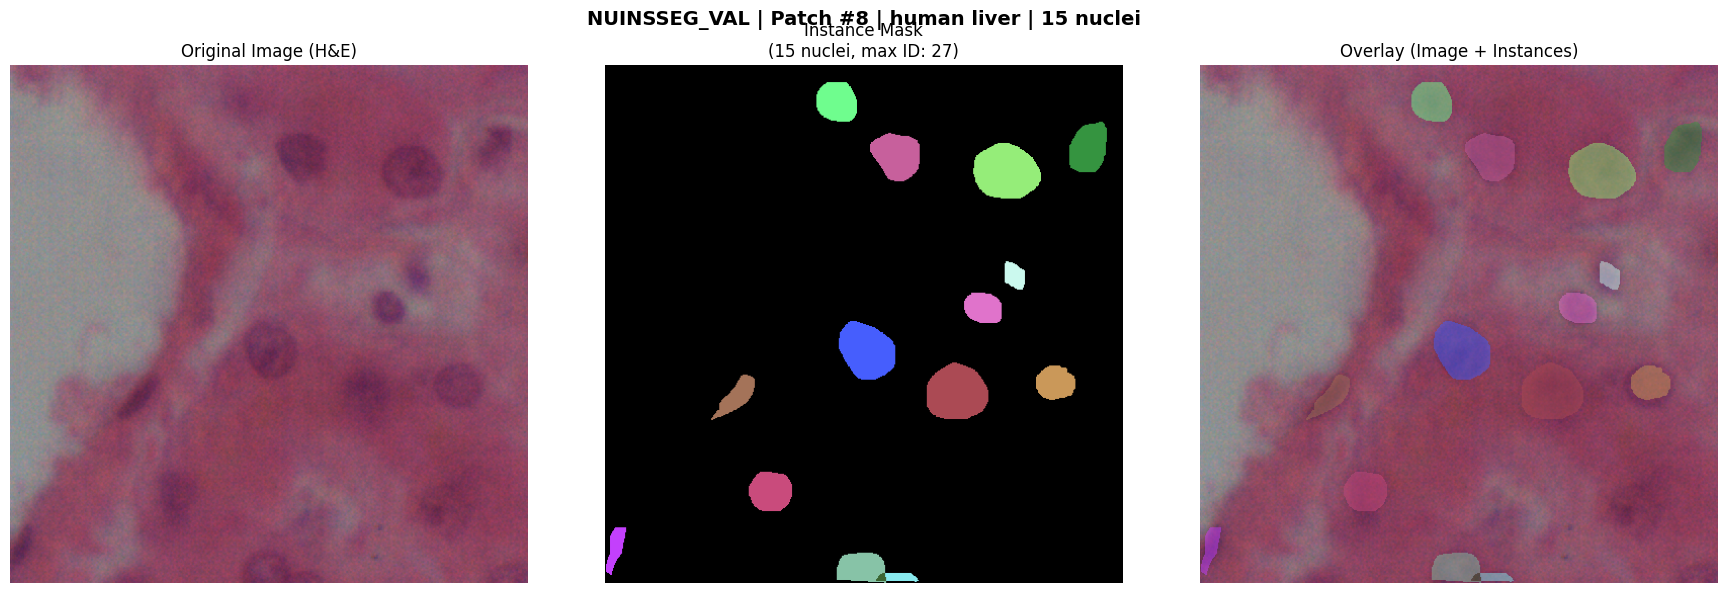

        ✅ Visualization complete

   [2/3] Patch #46
        Nuclei in patch: 18
        Size range: 130-776 pixels (avg: 397)
        Tissue type: mouse fat (white and brown)_subscapula
        Original file: mouse_subscapula_19.png
        Position: x=0, y=0
        Original size: 512x512


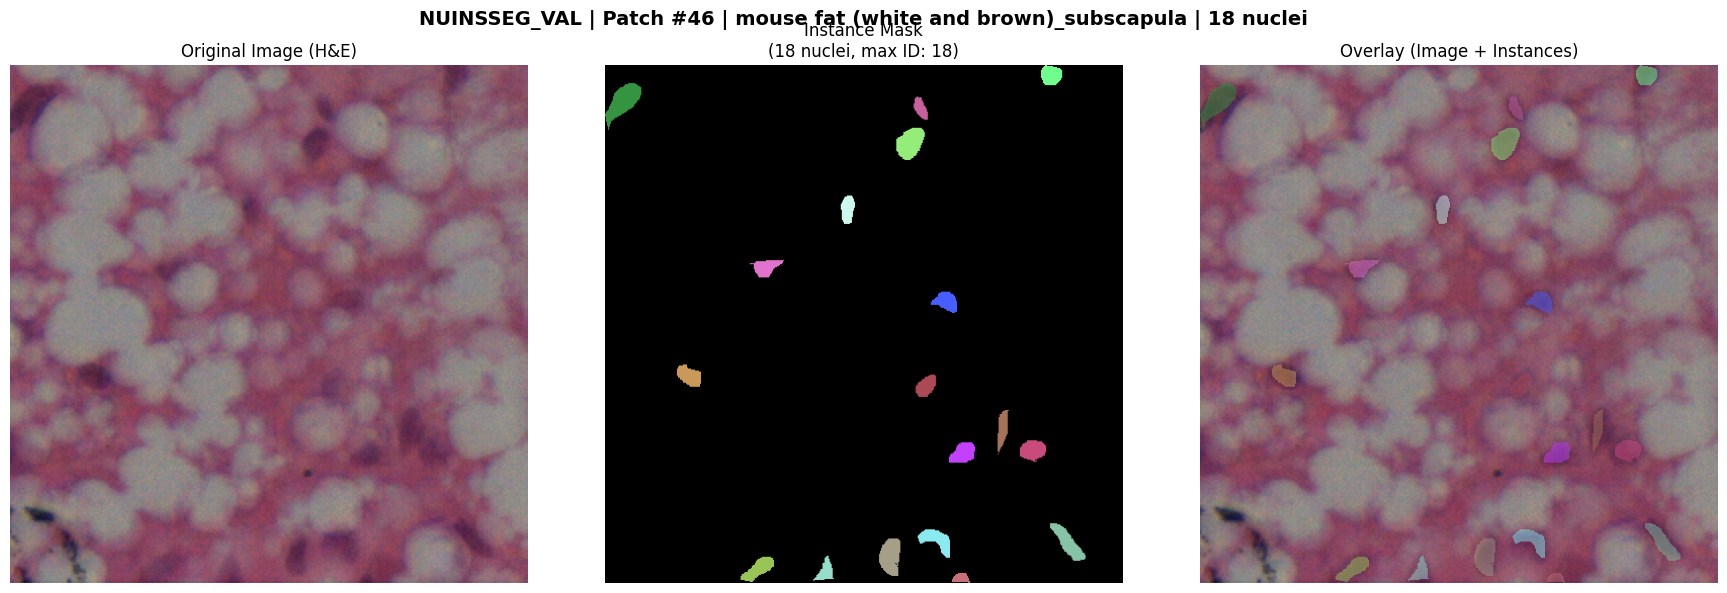

        ✅ Visualization complete

   [3/3] Patch #65
        Nuclei in patch: 43
        Size range: 129-3902 pixels (avg: 1050)
        Tissue type: human pancreas
        Original file: human_pancreas_16.png
        Position: x=0, y=0
        Original size: 512x512


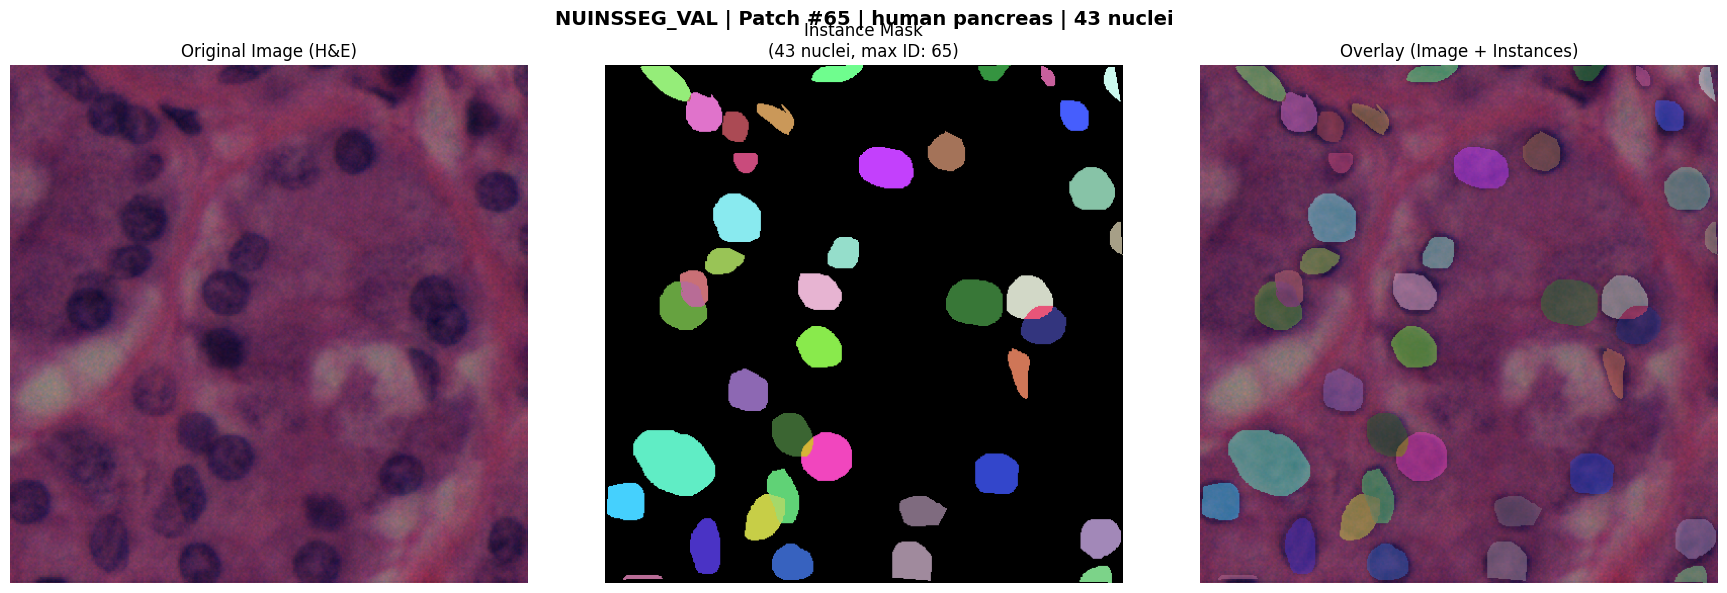

        ✅ Visualization complete

──────────────────────────────────────────────────────────────────────
📊 NUINSSEG_TEST
   Total patches: 100
   Showing: 3 random patches
──────────────────────────────────────────────────────────────────────

   [1/3] Patch #74
        Nuclei in patch: 49
        Size range: 214-1288 pixels (avg: 717)
        Tissue type: mouse kidney
        Original file: mouse_kidney_34.png
        Position: x=0, y=0
        Original size: 512x512


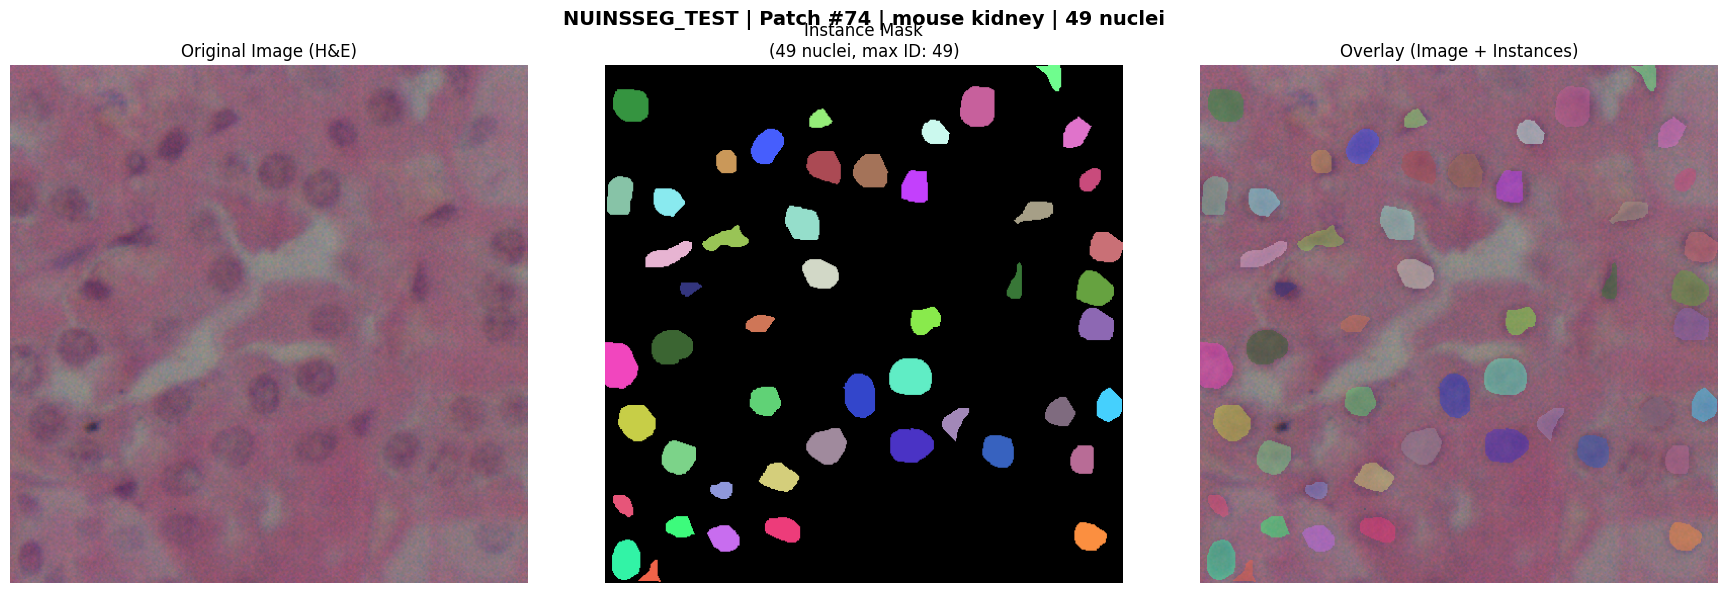

        ✅ Visualization complete

   [2/3] Patch #68
        Nuclei in patch: 74
        Size range: 1-1995 pixels (avg: 742)
        Tissue type: human liver
        Original file: human_liver_38.png
        Position: x=0, y=0
        Original size: 512x512


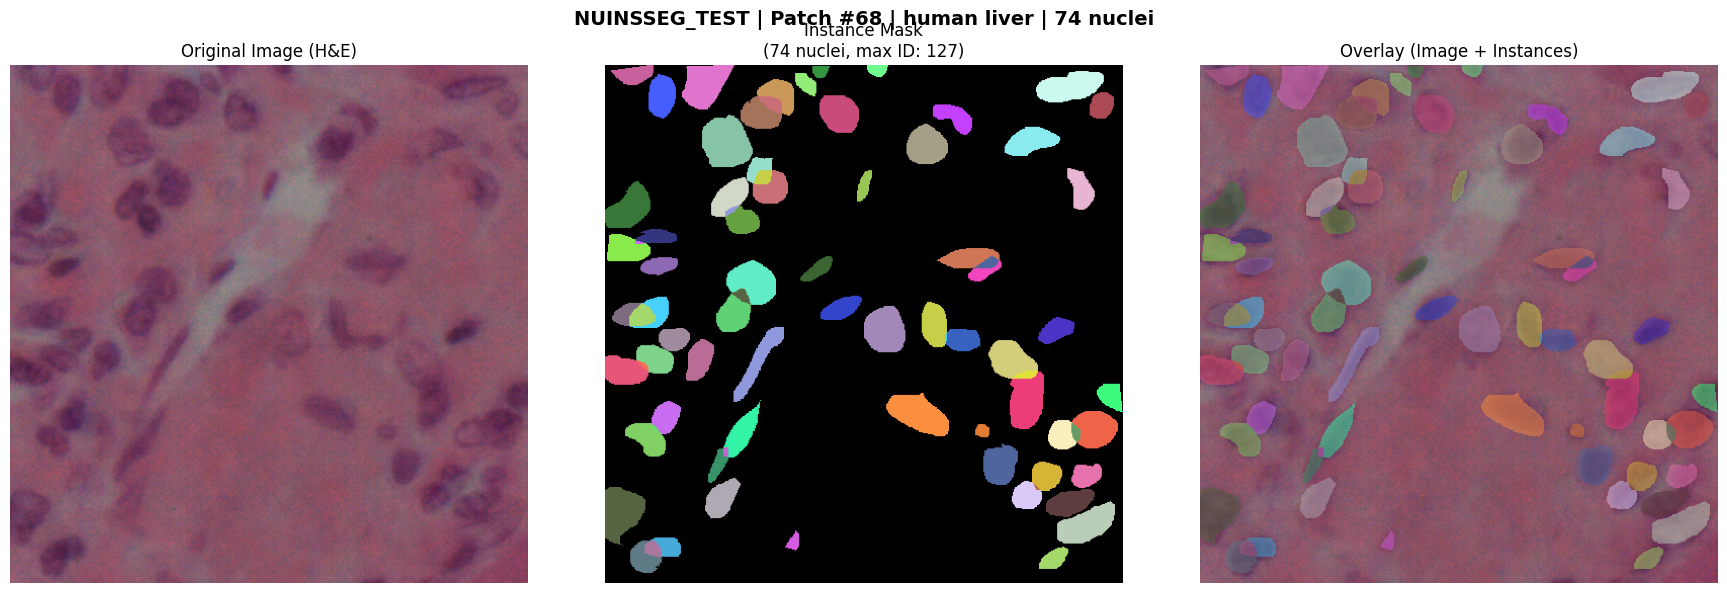

        ✅ Visualization complete

   [3/3] Patch #46
        Nuclei in patch: 14
        Size range: 237-3367 pixels (avg: 2030)
        Tissue type: mouse liver
        Original file: mouse_liver_34.png
        Position: x=0, y=0
        Original size: 512x512


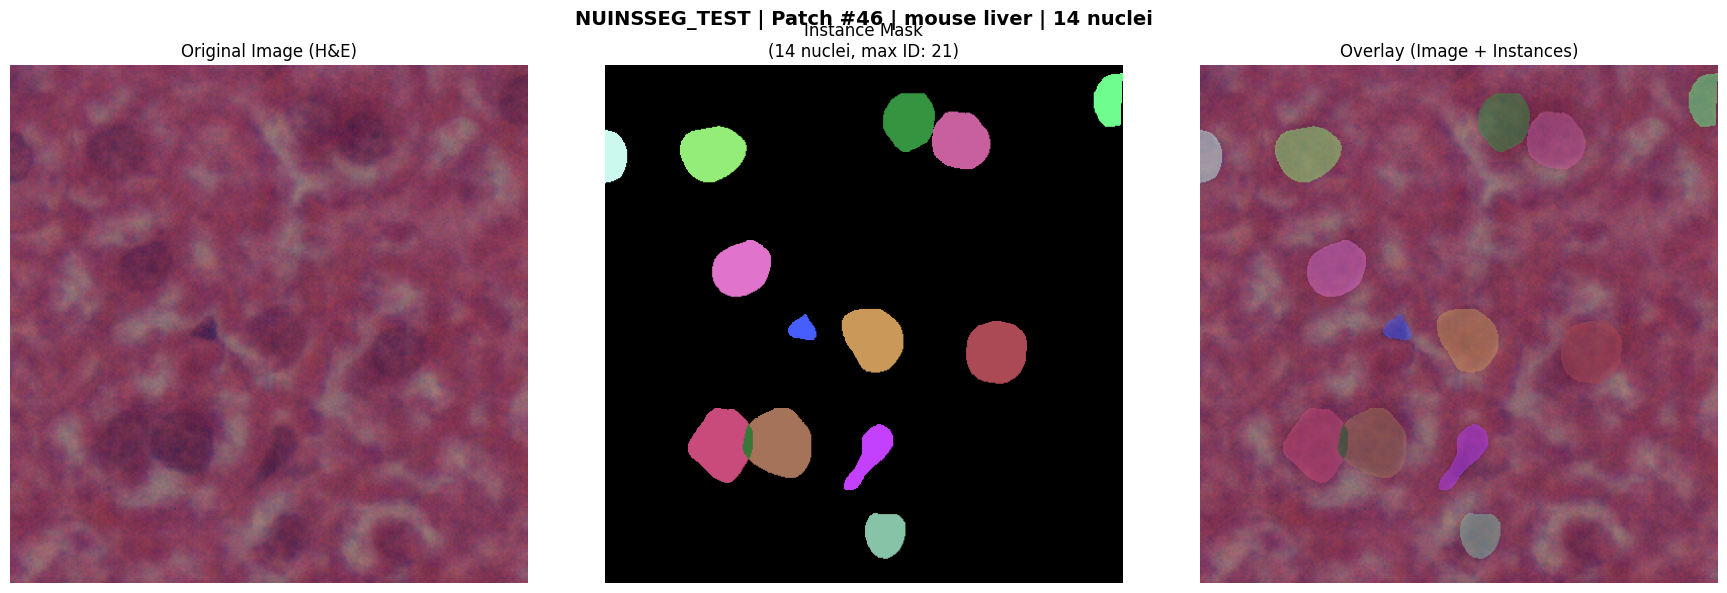

        ✅ Visualization complete

✅ Dataset inspection complete!


In [6]:
import zarr
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from pathlib import Path

# --- CONFIGURATION ---
ZARR_DATA_ROOT = Path("/rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/nuinsseg/zarr_data")

def colorize_instances(mask):
    """
    Creates a random RGB color map for an instance mask.
    Background (0) is always Black.
    Each unique instance ID gets a unique color.
    """
    max_id = int(mask.max())
    if max_id == 0:
        return np.zeros((*mask.shape, 3), dtype=np.uint8)
    
    # Create a random color for every possible ID
    # Using a fixed seed so colors are consistent for the same mask, 
    # but random across IDs.
    np.random.seed(42) 
    colors = np.random.randint(50, 255, size=(max_id + 1, 3), dtype=np.uint8)
    
    # Force background to black
    colors[0] = [0, 0, 0]
    
    # Map the IDs to colors
    colored_mask = colors[mask]
    return colored_mask

def get_instance_stats(mask):
    """Get statistics about instances in the mask"""
    unique_ids = np.unique(mask)
    num_instances = len(unique_ids[unique_ids > 0])  # Exclude background
    
    instance_sizes = []
    for inst_id in unique_ids:
        if inst_id > 0:
            size = np.sum(mask == inst_id)
            instance_sizes.append(size)
    
    return {
        'num_instances': num_instances,
        'min_size': min(instance_sizes) if instance_sizes else 0,
        'max_size': max(instance_sizes) if instance_sizes else 0,
        'avg_size': np.mean(instance_sizes) if instance_sizes else 0
    }

def visualize_dataset(root_path, samples_per_split=5):
    """
    Visualize random samples from the NuInsSeg zarr dataset.
    Works with nuinsseg_train, nuinsseg_val, nuinsseg_test directories.
    """
    
    print("=" * 70)
    print(f"👀 INSPECTING NuInsSeg ZARR DATA AT: {root_path}")
    print("=" * 70)
    
    if not root_path.exists():
        print(f"\n❌ Path not found: {root_path}")
        return
    
    # Get all split directories
    splits = ['nuinsseg_train', 'nuinsseg_val', 'nuinsseg_test']
    available_splits = [s for s in splits if (root_path / s).exists()]
    
    if not available_splits:
        print(f"\n⚠️  No split directories found in {root_path}")
        return
    
    print(f"\n{'─' * 70}")
    print(f"📂 NuInsSeg DATASET")
    print(f"   Available splits: {', '.join(available_splits)}")
    print(f"{'─' * 70}")
    
    for split_name in available_splits:
        split_path = root_path / split_name
        
        try:
            # Open zarr arrays
            z_img = zarr.open(str(split_path / "images.zarr"), mode='r')
            z_msk = zarr.open(str(split_path / "nuclei_masks.zarr"), mode='r')
            
            # Get metadata if available
            metadata_path = split_path / "metadata.csv"
            if metadata_path.exists():
                import pandas as pd
                metadata = pd.read_csv(metadata_path)
            else:
                metadata = None
            
            num_patches = z_img.shape[0]
            
            print(f"\n{'─' * 70}")
            print(f"📊 {split_name.upper()}")
            print(f"   Total patches: {num_patches}")
            print(f"   Showing: {min(samples_per_split, num_patches)} random patches")
            print(f"{'─' * 70}")
            
            # Randomly select patches to visualize
            num_samples = min(samples_per_split, num_patches)
            random_indices = random.sample(range(num_patches), num_samples)
            
            for sample_idx, idx in enumerate(random_indices, 1):
                img_patch = z_img[idx]
                mask_patch = z_msk[idx]
                
                # Get instance statistics
                stats = get_instance_stats(mask_patch)
                
                # Print info
                print(f"\n   [{sample_idx}/{num_samples}] Patch #{idx}")
                print(f"        Nuclei in patch: {stats['num_instances']}")
                if stats['num_instances'] > 0:
                    print(f"        Size range: {stats['min_size']}-{stats['max_size']} pixels (avg: {stats['avg_size']:.0f})")
                
                if metadata is not None:
                    patch_meta = metadata.iloc[idx]
                    print(f"        Tissue type: {patch_meta['tissue_type']}")
                    print(f"        Original file: {patch_meta['original_file']}")
                    print(f"        Position: x={patch_meta['x']}, y={patch_meta['y']}")
                    print(f"        Original size: {patch_meta['original_width']}x{patch_meta['original_height']}")
                
                # --- PLOTTING ---
                fig, ax = plt.subplots(1, 3, figsize=(18, 6))
                
                tissue_info = ""
                if metadata is not None:
                    tissue_info = f" | {metadata.iloc[idx]['tissue_type']}"
                
                fig.suptitle(
                    f"{split_name.upper()} | Patch #{idx}{tissue_info} | {stats['num_instances']} nuclei",
                    fontsize=14,
                    fontweight='bold'
                )
                
                # 1. Original Image
                ax[0].imshow(img_patch)
                ax[0].set_title("Original Image (H&E)", fontsize=12)
                ax[0].axis('off')
                
                # 2. Instance Mask (Random Colors)
                colored_mask = colorize_instances(mask_patch)
                ax[1].imshow(colored_mask)
                ax[1].set_title(
                    f"Instance Mask\n({stats['num_instances']} nuclei, max ID: {mask_patch.max()})",
                    fontsize=12
                )
                ax[1].axis('off')
                
                # 3. Overlay
                overlay_img = img_patch.copy().astype(float)
                
                # Create alpha channel based on mask
                alpha = np.where(mask_patch > 0, 0.5, 0.0)  # 50% transparency for nuclei
                
                # Blend the colored mask with the original image
                for c in range(3):
                    overlay_img[:, :, c] = (
                        img_patch[:, :, c] * (1 - alpha) + 
                        colored_mask[:, :, c] * alpha
                    )
                
                overlay_img = overlay_img.astype(np.uint8)
                
                ax[2].imshow(overlay_img)
                ax[2].set_title("Overlay (Image + Instances)", fontsize=12)
                ax[2].axis('off')
                
                plt.tight_layout()
                plt.show()
                print(f"        ✅ Visualization complete")
            
        except Exception as e:
            print(f"\n        ❌ Error reading {split_name}: {e}")
            import traceback
            traceback.print_exc()
    
    print("\n" + "=" * 70)
    print("✅ Dataset inspection complete!")
    print("=" * 70)

def print_dataset_summary(root_path):
    """Print summary statistics for the entire NuInsSeg dataset"""
    
    print("\n" + "=" * 70)
    print("📊 NuInsSeg DATASET SUMMARY")
    print("=" * 70)
    
    if not root_path.exists():
        print(f"❌ Path not found: {root_path}")
        return
    
    splits = ['nuinsseg_train', 'nuinsseg_val', 'nuinsseg_test']
    available_splits = [s for s in splits if (root_path / s).exists()]
    
    if not available_splits:
        print("⚠️  No split directories found")
        return
    
    total_patches = 0
    total_nuclei = 0
    split_info = []
    
    for split_name in available_splits:
        split_path = root_path / split_name
        
        try:
            z_msk = zarr.open(str(split_path / "nuclei_masks.zarr"), mode='r')
            num_patches = z_msk.shape[0]
            total_patches += num_patches
            
            # Count nuclei in all patches (sample first 100 for speed)
            sample_size = min(100, num_patches)
            sample_nuclei = 0
            
            for patch_idx in range(sample_size):
                mask = z_msk[patch_idx]
                unique_ids = np.unique(mask)
                sample_nuclei += len(unique_ids[unique_ids > 0])
            
            # Estimate total nuclei
            estimated_nuclei = int(sample_nuclei * (num_patches / sample_size))
            total_nuclei += estimated_nuclei
            
            split_info.append({
                'name': split_name,
                'patches': num_patches,
                'nuclei': estimated_nuclei,
                'sampled': sample_size
            })
            
        except Exception as e:
            print(f"⚠️  Error processing {split_name}: {e}")
    
    print(f"\nTotal splits: {len(available_splits)}")
    print(f"Total patches: {total_patches}")
    print(f"Total nuclei (estimated): {total_nuclei}")
    if total_patches > 0:
        print(f"Avg nuclei/patch: {total_nuclei/total_patches:.1f}")
    
    print(f"\n{'─' * 70}")
    print("Per-split breakdown:")
    print(f"{'─' * 70}")
    for info in split_info:
        avg_per_patch = info['nuclei'] / info['patches'] if info['patches'] > 0 else 0
        print(f"   {info['name']}: {info['patches']} patches, ~{info['nuclei']} nuclei (avg: {avg_per_patch:.1f}/patch)")
        print(f"      (estimated from {info['sampled']} sampled patches)")
    
    # Tissue distribution from metadata
    print(f"\n{'─' * 70}")
    print("Tissue type distribution:")
    print(f"{'─' * 70}")
    
    for split_name in available_splits:
        split_path = root_path / split_name
        metadata_path = split_path / "metadata.csv"
        
        if metadata_path.exists():
            import pandas as pd
            metadata = pd.read_csv(metadata_path)
            tissue_counts = metadata['tissue_type'].value_counts()
            
            print(f"\n   {split_name}:")
            for tissue, count in tissue_counts.head(10).items():
                print(f"      {tissue}: {count} patches")
            
            if len(tissue_counts) > 10:
                print(f"      ... and {len(tissue_counts) - 10} more tissues")
    
    print("\n" + "=" * 70)

def verify_data_integrity(root_path):
    """Check for common issues in the dataset"""
    print("\n" + "=" * 70)
    print("🔍 DATA INTEGRITY CHECK")
    print("=" * 70)
    
    if not root_path.exists():
        print(f"❌ Path not found: {root_path}")
        return
    
    splits = ['nuinsseg_train', 'nuinsseg_val', 'nuinsseg_test']
    available_splits = [s for s in splits if (root_path / s).exists()]
    
    issues = []
    
    for split_name in available_splits:
        split_path = root_path / split_name
        
        # Check for required files
        if not (split_path / "images.zarr").exists():
            issues.append(f"{split_name}: Missing images.zarr")
        if not (split_path / "nuclei_masks.zarr").exists():
            issues.append(f"{split_name}: Missing nuclei_masks.zarr")
        if not (split_path / "metadata.csv").exists():
            issues.append(f"{split_name}: Missing metadata.csv")
        
        try:
            z_img = zarr.open(str(split_path / "images.zarr"), mode='r')
            z_msk = zarr.open(str(split_path / "nuclei_masks.zarr"), mode='r')
            
            # Check shape consistency
            if z_img.shape[0] != z_msk.shape[0]:
                issues.append(f"{split_name}: Image/mask count mismatch ({z_img.shape[0]} vs {z_msk.shape[0]})")
            
            # Check patch dimensions
            if z_img.shape[1:3] != (512, 512):
                issues.append(f"{split_name}: Incorrect image patch size {z_img.shape[1:3]}")
            if z_msk.shape[1:3] != (512, 512):
                issues.append(f"{split_name}: Incorrect mask patch size {z_msk.shape[1:3]}")
            
            # Check data types
            if z_img.dtype != np.uint8:
                issues.append(f"{split_name}: Image dtype should be uint8, got {z_img.dtype}")
            if z_msk.dtype != np.int32:
                issues.append(f"{split_name}: Mask dtype should be int32, got {z_msk.dtype}")
            
            # Sample check: verify at least one patch has nuclei
            has_nuclei = False
            for idx in range(min(10, z_msk.shape[0])):  # Check first 10 patches
                if z_msk[idx].max() > 0:
                    has_nuclei = True
                    break
            
            if not has_nuclei:
                issues.append(f"{split_name}: Warning - No nuclei found in first 10 patches")
            
            # Check metadata consistency
            metadata_path = split_path / "metadata.csv"
            if metadata_path.exists():
                import pandas as pd
                metadata = pd.read_csv(metadata_path)
                
                if len(metadata) != z_img.shape[0]:
                    issues.append(f"{split_name}: Metadata row count ({len(metadata)}) doesn't match patch count ({z_img.shape[0]})")
                
                # Check required columns
                required_cols = ['tissue_type', 'original_file', 'x', 'y', 'original_height', 'original_width']
                missing_cols = [col for col in required_cols if col not in metadata.columns]
                if missing_cols:
                    issues.append(f"{split_name}: Missing metadata columns: {missing_cols}")
                
        except Exception as e:
            issues.append(f"{split_name}: Error reading zarr - {e}")
    
    if issues:
        print("\n⚠️  Issues found:")
        for issue in issues:
            print(f"   • {issue}")
    else:
        print("\n✅ All checks passed! Dataset looks good.")
    
    print("\n" + "=" * 70)

if __name__ == "__main__":
    if ZARR_DATA_ROOT.exists():
        # First verify data integrity
        verify_data_integrity(ZARR_DATA_ROOT)
        
        # Print overall summary
        print_dataset_summary(ZARR_DATA_ROOT)
        
        # Then visualize random samples
        print("\n")
        visualize_dataset(ZARR_DATA_ROOT, samples_per_split=3)
    else:
        print(f"❌ Path not found: {ZARR_DATA_ROOT}")
        print("   Please check your ZARR_DATA_ROOT configuration.")